In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import Scripts.airfoil as af
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve
import Scripts.fishClass
import pathlib

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

In [34]:
def power_law(xData, a, b):
        return a * xData ** b

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [35]:
dataBase = r'/home/mco143/Documents/gitRepos/fish_contours/PhillipsFitData.xlsx'
phillipsData = r'/home/mco143/Documents/gitRepos/fish_contours/phillips_COT_data.xlsx'

In [36]:
# Fit Data
generalData = pd.read_excel(dataBase, sheet_name='General')
sideData = pd.read_excel(dataBase, sheet_name='Side Fit')
topData = pd.read_excel(dataBase, sheet_name='Top Fit')

# Phillips COT data
totalCOT = pd.read_excel(phillipsData, sheet_name="TotalCOTData")
optCOT = pd.read_excel(phillipsData, sheet_name="OptimumCOT")
hotelpower = pd.read_excel(phillipsData, sheet_name="HotelPower")
BMR = pd.read_excel(phillipsData, sheet_name="BMR")


In [37]:
# get species names
specimens = generalData['Species Name'].tolist()

In [38]:
lengthScales = np.linspace(0.01, 100, 50)

specimen = specimens[0]
idy = 0
sArea = np.zeros((len(lengthScales), len(specimens)))
D_calc = np.zeros((len(lengthScales), len(specimens)))
volume = np.zeros((len(lengthScales), len(specimens)))
blenderSA = np.zeros(len(lengthScales))
blenderVol = np.zeros(len(lengthScales))

for idy, specimen in enumerate(specimens):   
    sidePolyTop = sideData.loc[[idy],['Ta6', 'Ta5', 'Ta4', 'Ta3', 'Ta2', 'Ta1', 'Ta0']].values[0]
    sidePolyBottom = sideData.loc[[idy],['Ba6', 'Ba5', 'Ba4', 'Ba3', 'Ba2', 'Ba1', 'Ba0']].values[0]
    topNaca = topData.loc[[idy], ['Ta4', 'Ta3', 'Ta2']].values[0]
    sideArea = generalData.loc[[idy], ['Side Area']].values[0][0]
    topArea = generalData.loc[[idy], ['Top Area']].values[0][0]
    
    if (specimen == 'blenderSalmon'):
        for idx, length in enumerate(lengthScales):
            sArea[idx, idy], D_calc[idx, idy] = sea.determine_surface_area(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)
            blenderSA[idx] = sArea[idx, idy]
            volume[idx, idy] = ve.determine_volume(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)
            blenderVol[idx] = volume[idx, idy]
    else:   
        for idx, length in enumerate(lengthScales):
            sArea[idx, idy], D_calc[idx, idy] = sea.determine_surface_area(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)
            volume[idx, idy] = ve.determine_volume(1, 2, 0, length, sidePolyTop, sidePolyBottom, topNaca, topNaca)

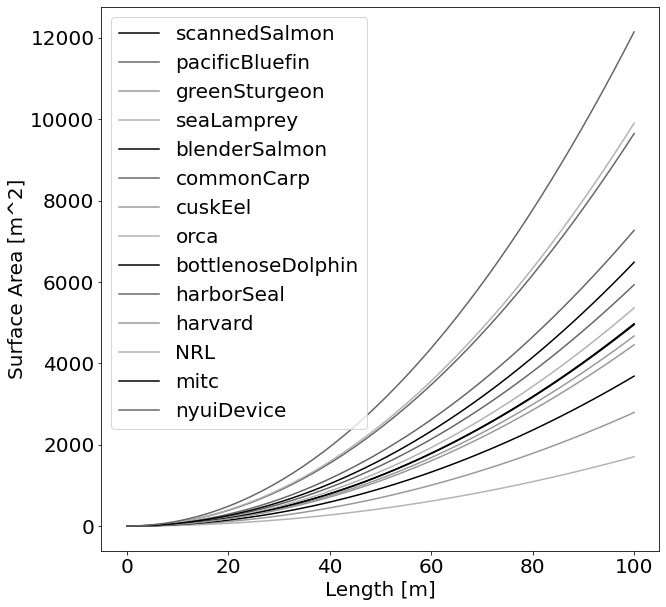

In [53]:
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plt.subplots(figsize=((10, 10)))
fig1.set_facecolor('white')
for idy, specimen in enumerate(specimens):
    ax1.plot(lengthScales, sArea[:, idy], label=specimen)

ax1.set_ylabel('Surface Area [m^2]')
ax1.set_xlabel('Length [m]')
ax1.legend()

In [40]:
scalingData = r'blenderSalmonScaling.xlsx'

scaleDF = pd.read_excel(scalingData)
scaledLength = scaleDF['Length'].values
scaledArea = scaleDF['Area'].values
scaledVolume = scaleDF['Volume'].values

In [41]:
# convert from cm to meters
# area in m^2 and volume in m^3
scaledArea = scaledArea * (1/100**2)
scaledVolume = scaledVolume * (1/100**3)

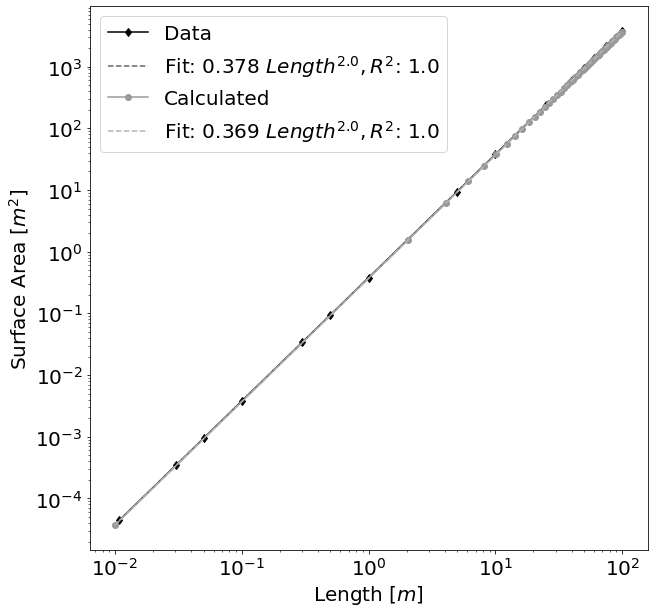

In [52]:
plt.style.use('grayscale')
popt_scaled, r_squared_scaled = fit_data(scaledLength, scaledArea)
popt_blender, r_squared_blender = fit_data(lengthScales, blenderSA)

fig2, ax2 = plt.subplots(figsize=((10, 10)))
fig2.set_facecolor('white')
ax2.loglog(scaledLength, scaledArea, '-d', label='Data')
ax2.loglog(scaledLength, power_law(scaledLength, *popt_scaled), '--', label="Fit: " + str(np.round(popt_scaled[0], 3)) + " $Length^{" + str(np.round(popt_scaled[1], 3)) + '}, R^2$: ' + str(np.round(r_squared_scaled, 2)))
ax2.loglog(lengthScales, blenderSA, '-o', label = 'Calculated')
ax2.loglog(lengthScales, power_law(lengthScales, *popt_blender), '--', label="Fit: " + str(np.round(popt_blender[0], 3)) + " $Length^{" + str(np.round(popt_blender[1], 3)) + '}, R^2$: ' + str(np.round(r_squared_blender, 2)))
ax2.set_ylabel('Surface Area $[m^2]$')
ax2.set_xlabel('Length $[m]$')
ax2.legend()

In [43]:
mammal_hp = BMR.loc[BMR['Species']=='Mammal']
eel_hp = BMR.loc[BMR['Species']=='Eel']
salmon_hp = BMR.loc[BMR['Species']=='Salmonoid']
AUV_hp = BMR.loc[BMR['Species']=='AUV']
glider_hp = BMR.loc[BMR['Species']=='Glider']

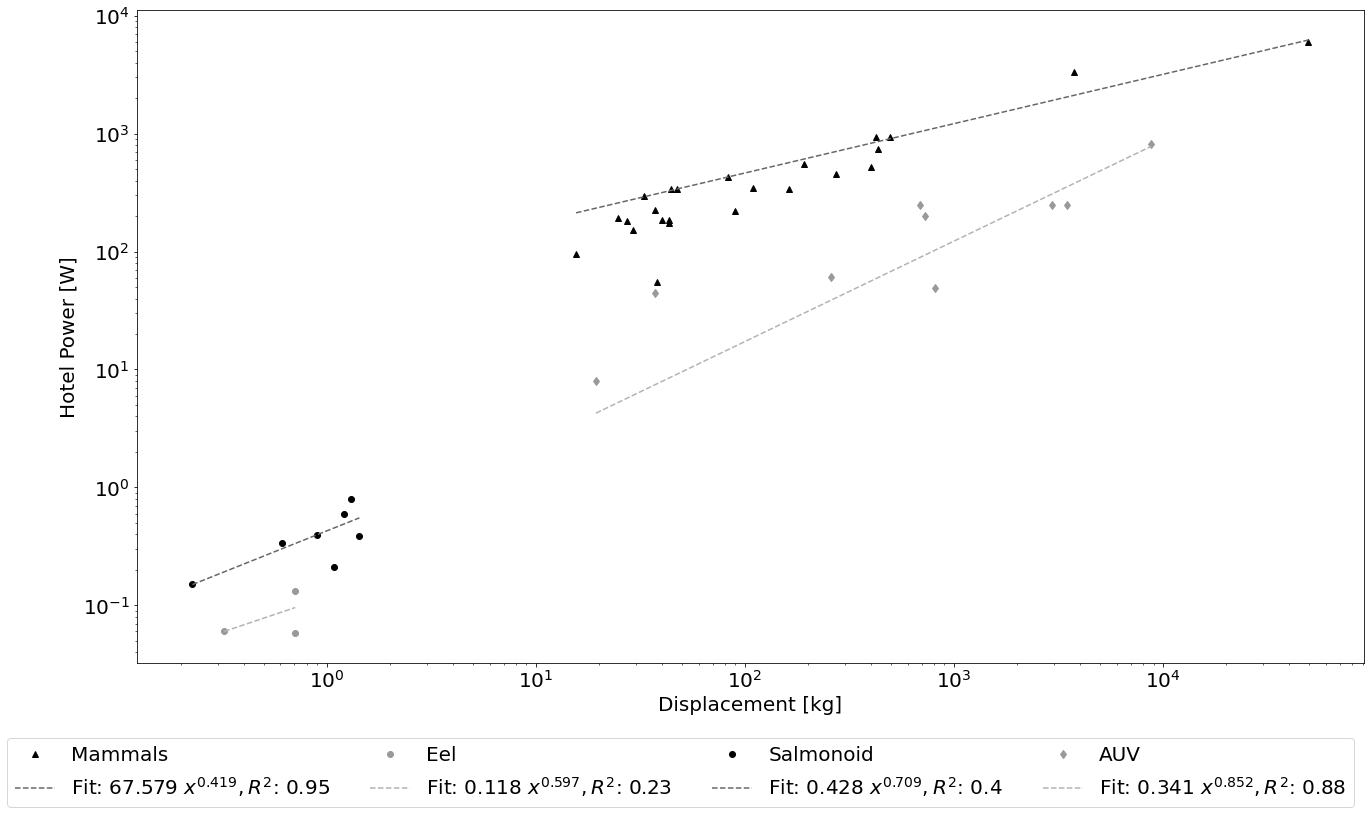

In [51]:
popt_mammal, r_sq_mammal = fit_data(mammal_hp["Displacement"].values, mammal_hp["MR"].values)
popt_eel, r_sq_eel = fit_data(eel_hp["Displacement"].values, eel_hp["MR"].values)
popt_salmon, r_sq_salmon = fit_data(salmon_hp["Displacement"].values, salmon_hp["MR"].values)
popt_AUV, r_sq_AUV = fit_data(AUV_hp["Displacement"].values, AUV_hp["MR"].values)
#popt_glider, r_sq_glider = fit_data(glider_hp["Displacement"].values, glider_hp["MR"].values)


fig3, ax3 = plt.subplots(figsize=((22, 12)))
fig3.set_facecolor('white')
ax3.loglog(mammal_hp["Displacement"].values, mammal_hp["MR"].values, '^', label='Mammals')
ax3.loglog(mammal_hp["Displacement"].values, power_law(mammal_hp["Displacement"].values, *popt_mammal), '--', label="Fit: " + str(np.round(popt_mammal[0], 3)) + " $x^{" + str(np.round(popt_mammal[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_mammal, 2)))
ax3.loglog(eel_hp["Displacement"].values, eel_hp["MR"].values, 'o', label='Eel')
ax3.loglog(eel_hp["Displacement"].values, power_law(eel_hp["Displacement"].values, *popt_eel), '--', label="Fit: " + str(np.round(popt_eel[0], 3)) + " $x^{" + str(np.round(popt_eel[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_eel, 2)))
ax3.loglog(salmon_hp["Displacement"].values, salmon_hp["MR"].values, 'o', label='Salmonoid')
ax3.loglog(salmon_hp["Displacement"].values, power_law(salmon_hp["Displacement"].values, *popt_salmon), '--', label="Fit: " + str(np.round(popt_salmon[0], 3)) + " $x^{" + str(np.round(popt_salmon[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_salmon, 2)))
ax3.loglog(AUV_hp["Displacement"].values, AUV_hp["MR"].values, 'd', label='AUV')
ax3.loglog(AUV_hp["Displacement"].values, power_law(AUV_hp["Displacement"].values, *popt_AUV), '--', label="Fit: " + str(np.round(popt_AUV[0], 3)) + " $x^{" + str(np.round(popt_AUV[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_AUV, 2)))
ax3.set_ylabel('Hotel Power [W]')
ax3.set_xlabel('Displacement [kg]')
ax3.legend(ncol=4, bbox_to_anchor=(1.0, -0.1))